## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [ ]:
# ! python -m pip install tensorboardX

In [2]:
def plot_data(data, figsize=(16, 4), file_name=None):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
    if file_name is not None:
        plt.savefig(file_name)
    else:
        plt.show()

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

W1018 19:16:39.889080 140717010437888 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
waveglow_path = '/home/nguyen.thanh.trungb/Desktop/TTS_Project/outdir/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']

for m in waveglow.modules():
    if 'Conv' in str(type(m)):
        setattr(m, 'padding_mode', 'zeros')
        
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Decode text input and plot results

In [5]:
import glob
from random import shuffle


texts = [" -- đêm hôm_đó , đào về_nhà . lúc đó trời đã nhá_nhem , con_chó nhà hàng_xóm sủa lên từng hồi thảm_thiết ..",
        " -- bạn cho_rằng bạn đẹp , vẻ_đẹp như bạn thì phải xứng_đáng với một chàng hoàng_tử ..",
        " -- cũng được_thôi , nếu bạn nhận định giá_trị của mình ở mức_độ như vậy ..",
        " -- cô ấy vẫn cưới đại_gia bình_thường , vì cô ấy là người có giá trị về học_vấn và tài_năng .. "
       ]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
checkpoint_13650_0_3582060005929735    -- cũng được_thôi , nếu bạn n
Warning! Reached max decoder steps


checkpoint_13650_0_3582060005929735    -- cũng được_thôi , nếu bạn n


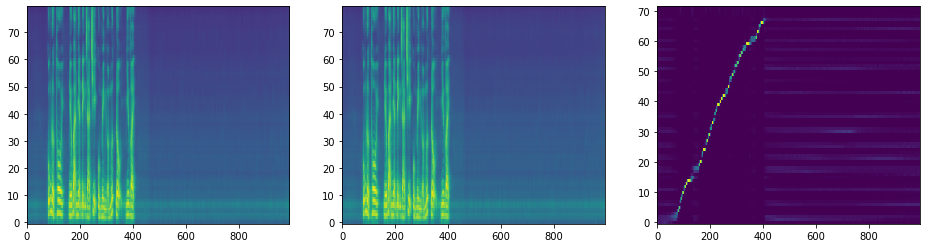

In [8]:
%load_ext autoreload
%autoreload 2

from train import load_model


file_dirs = ["/home/nguyen.thanh.trungb/Desktop/TTS_Project/tacotron2/outdir/checkpoint_13650_0_3582060005929735"]
output_layers = [None, None]

for i, checkpoint_path in enumerate(file_dirs):
    model = load_model(hparams)
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    _ = model.cuda().eval().half()

    for text in texts[2:3]:
        for j in range(2):
            print(checkpoint_path.split("/")[-1], " ", text[:30])
            sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
            sequence = torch.autograd.Variable(
            torch.from_numpy(sequence)).cuda().long()
            mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
            
            plot_data((mel_outputs.float().data.cpu().numpy()[0],
                       mel_outputs_postnet.float().data.cpu().numpy()[0],
                       alignments.float().data.cpu().numpy()[0].T))


In [5]:
checkpoint_path = "/home/nguyen.thanh.trungb/Desktop/TTS_Project/tacotron2/outdir/checkpoint_13650_0_3582060005929735"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

normalize_text  -- đừng làm áng mây trôi trên bầu_trời , một_mình chơi_vơi ..


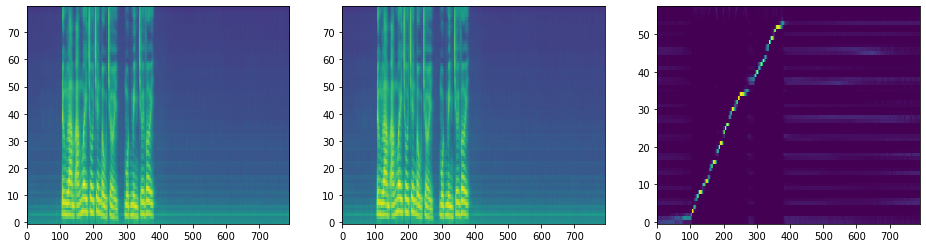

In [212]:
from train import load_model


text = "Đừng làm áng mây trôi trên bầu trời, một mình chơi vơi"
# text = texts[2]
sequence = np.array(text_to_sequence(text, ['basic_cleaners'], language='vn', normalize=True))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

audio_denoised = denoiser(audio, strength=0.01)[:, 0].cpu().numpy()
ipd.Audio(audio_denoised, rate=hparams.sampling_rate) 

In [213]:

print(audio_denoised.shape)
# plt.plot(audio_denoised)
# plt.show()
import librosa
trim_audio, index = librosa.effects.trim(audio_denoised, top_db=20)
ipd.Audio(trim_audio, rate=hparams.sampling_rate) 

(1, 202496)


In [20]:
!pip install pydub

  Using cached https://files.pythonhosted.org/packages/79/db/eaf620b73a1eec3c8c6f8f5b0b236a50f9da88ad57802154b7ba7664d0b8/pydub-0.23.1-py2.py3-none-any.whl


#### (Optional) Remove WaveGlow bias

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from utils import load_wav_to_torch

audio, rate = load_wav_to_torch("/home/nguyen.thanh.trungb/Desktop/TTS_Project/Dataset/data_bachuc/split/1561706150.9373183_test.wav")